In [1]:
pip install sklearn pyts matplotlib albumentations h5py 

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 97 kB 5.2 MB/s eta 0:00:011
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=4d1810da9d09df6761a236f326aa3867ac38be59e21a66eb8887395287bbb514
  Stored in directory: /home/jovyan/.cache/pip/wheels/68/11/97/886e5796b655bf28bf4a0d75e933ea71c6d7d34be701168d1d
Successfully built gdown
Note: you may need to restart the kernel to use updated packages.


In [2]:
!conda install cudnn=8.1 cudatoolkit=11.2 --yes --quiet -c nvidia -c defaults
!pip install tensorflow==2.5 --quiet

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cudatoolkit=11.2
    - cudnn=8.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.26 |       h06a4308_2         115 KB  defaults
    certifi-2021.10.8          |   py39h06a4308_0         151 KB  defaults
    cudatoolkit-11.2.72        |       h2bc3f7f_0       933.4 MB  nvidia
    cudnn-8.1.0.77             |       h90431f1_0       634.8 MB  conda-forge
    openssl-1.1.1l             |       h7f8727e_0         2.5 MB  defaults
    ------------------------------------------------------------
                                           Total:        1.53 GB

The following NEW packages will be INSTALLED:

  cudatoolkit        nvidia/linux-64::cu

In [39]:
import time
from IPython.display import clear_output

count = 0
while True:
    count = count +1
    print(count)
    time.sleep(1)
    clear_output(wait=True)

30692


KeyboardInterrupt: 

In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2021-11-28 00:25:35.741607: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2021-11-28 00:25:36.855945: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-28 00:25:36.903866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 00:25:36.904055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-28 00:25:36.904075: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-28 00:25:36.911112: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-28 00:25:36.911148: I tensorflow/stream_executor/

In [2]:
def plot_confusion_matrix_norm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    

    plt.title(title)



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')
    plt.colorbar()

In [3]:
def LSTM_3D(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a) 
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6 #return sequences = True
    prediction = Dense(num_classes, activation='softmax')(out)

    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [4]:
def LSTM_3D_V56(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #out = Dropout(0.10)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [5]:
def basic_cnn_functional(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])
    
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(input_a)
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.10)(x)

    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = Flatten()(out)
    # dense layer with 50 neurons
    dense = Dense(64, activation = 'relu')(out)
    # final layer with 10 neurons to classify the instances
    output = Dense(num_classes, activation = 'softmax')(dense)
    
    adam = optimizers.Adam(lr = lr)
    model = keras.models.Model(inputs=input_a, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [7]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [8]:
path

'/home/jovyan/work/Untitled Folder/nilm'

In [11]:
train = file["data/train/gaf"][0:10]

In [12]:
train.shape[1:]

(5, 100, 100, 1)

In [49]:
#fetch array of appliances
enc_appliances = np.array(file["appliances/classes"])
appliances = [n.decode("utf-8") for n in enc_appliances]
num_of_classes = file["appliances/classes"].shape[0]
#manualy_selected_appliances.remove("microwave")

#fetch array of weights
#class_weights = np.array(file["classes/weights"])
#class_weights = np.delete(class_weights,5)
print(appliances)

#print(class_weights)

# #read train and label data
#data_train = np.array(file['data/train']['gasf'])
X_test = np.array(file['data/test']['gaf'])
#y_test = np.array(file['labels/test']['gasf'])
#y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)
y_test = np.array(file['labels/test']['gaf'])
labels_train = np.array(file['labels/train']['gaf'])

# X_train = np.array(file['data/train']['gaf'])
# X_test = np.array(file['data/test']['gaf'])

['HEKA', 'fridge/freezer', 'audio system', 'breadmaker', 'broadband router', 'computer', 'dehumidifier', 'dish washer', 'electric space heater', 'food processor', 'pond pump', 'television', 'tumble dryer', 'washer dryer', 'washing machine']


In [50]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)

In [14]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes = np.unique(labels_train), y=labels_train)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

{0: 0.3663356504468719, 1: 0.22525951557093427, 2: 6.4672023374726075, 3: 34.85669291338583, 4: 4.910482529118137, 5: 0.43032954214056574, 6: 18.068571428571428, 7: 2.8259176508139165, 8: 11.852208835341365, 9: 12.611965811965812, 10: 2.7789077212806026, 11: 0.2799203262828417, 12: 7.359600997506234, 13: 38.32727272727273, 14: 2.2073298429319372}


In [15]:
#train test split
print("...spliting")

print("loading labels")
Y = file["labels/gaf"][:]
print("loading images")
X =  file["data/gaf"]

x_ids = list(range(len(X)))

x_train_ids, x_test_ids = train_test_split(x_ids,test_size=0.2,random_state=12,stratify=Y)
print("split shapes shapes:")
print(len(x_train_ids))
print(len(x_test_ids))

...spliting
loading labels
loading images
split shapes shapes:
132804
33202


In [36]:
#read the file

train_gen = HDF5ImageGenerator(
    src= path_data,
    
    X_key="data/train/gaf",
    y_key="labels/train/gaf",
    classes_key="appliances/classes",
    labels_encoding="hot",
    shuffle=True,
    batch_size=64,
    num_classes=num_of_classes,
    mode="train",
   
    
    )

#test_gen = HDF5ImageGenerator(
#    src= path,
#    scaler=False,
#    X_key="data/test/gasf",
#    y_key="labels/test/gaf",
#    classes_key="classes/appliances",
#    labels_encoding="hot",
#    shuffle=False,
#    batch_size=32,
#    num_classes=num_of_classes,
#    mode="train"
#    )

In [37]:
model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

model.fit(
    train_gen,
    verbose=1,
    epochs=200,
    class_weight=d_class_weights,
    #max_queue_size = 10,
    #workers = 10
   
)

Epoch 1/200
2076/2076 [==============================] - 180s 86ms/step - loss: 2.4734 - accuracy: 0.1736
Epoch 2/200
2076/2076 [==============================] - 178s 86ms/step - loss: 1.9391 - accuracy: 0.3961
Epoch 3/200
2076/2076 [==============================] - 178s 86ms/step - loss: 1.5419 - accuracy: 0.5168
Epoch 4/200
2076/2076 [==============================] - 178s 86ms/step - loss: 1.2929 - accuracy: 0.5683
Epoch 5/200
2076/2076 [==============================] - 178s 86ms/step - loss: 1.1216 - accuracy: 0.6010
Epoch 6/200
2076/2076 [==============================] - 178s 86ms/step - loss: 0.9946 - accuracy: 0.6193
Epoch 7/200
2076/2076 [==============================] - 178s 86ms/step - loss: 0.8896 - accuracy: 0.6386
Epoch 8/200
2076/2076 [==============================] - 178s 86ms/step - loss: 0.8243 - accuracy: 0.6534
Epoch 9/200
2076/2076 [==============================] - 178s 86ms/step - loss: 0.7663 - accuracy: 0.6657
Epoch 10/200
2076/2076 [======================

In [38]:
path_model1 = path+"/models/refit/gen/model3"
model.save(path_model1)

2021-11-28 10:36:50.598765: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jovyan/work/Untitled Folder/nilm/models/refit/gen/model3/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/Untitled Folder/nilm/models/refit/gen/model3/assets


In [ ]:
model = keras.models.load_model(path_model1)
model_used = model

In [18]:
results = model_used.evaluate(X_test, y_test, verbose = 2)

2021-11-24 12:19:55.770846: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 7268000000 exceeds 10% of free system memory.


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1323 test_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1314 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1307 run_step  **
        outputs = model.test_step(data)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1268 test_step
        self.compiled_loss(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 22, 22) and (None, 22) are incompatible


In [44]:
model_used = model

2021-11-28 19:14:01.754775: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 6640400000 exceeds 10% of free system memory.


1038/1038 - 14s
[[6001   34    0    0    0    0    1    0    3    0    0    1    1    1
     0]
 [   0 9525    1    3   44    9    8    8    0   11    6  186    0    0
    25]
 [   0    0  306    0    0   13    0    0    0    0    0   23    0    0
     0]
 [   0    0    0   64    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    3    0    0  391   30    0    1    0    3    0   17    0    0
     6]
 [   1   18  105    1  316 4172   10    4   37    4   20  392    3    0
    60]
 [   0    0    0    0    0    0  117    1    2    0    0    0    3    0
     0]
 [   0    2    0    0    0    1    4  767    2    0    0    4    2    0
     1]
 [   0    0    2    0    0   10    2    1  164    0    0    8    0    0
     0]
 [   0    2    1    0    0    0    0    0    0  167    0    3    1    0
     1]
 [   0    0    0    0    0    4    0    0    0    0  790    2    0    0
     0]
 [   0  142  349    0  107  550   13    5   21   29  199 6459    2    1
    31]
 [   0    0    0    2   

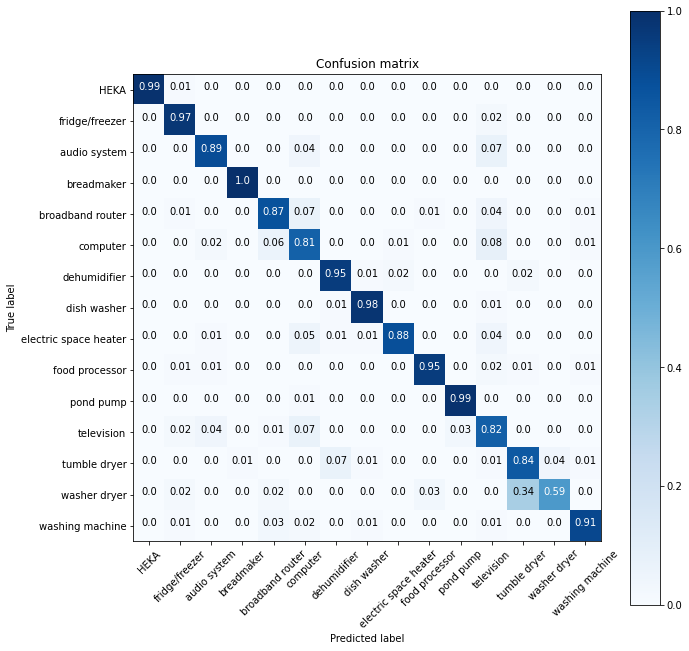

In [51]:
#Print results and plot confusion matrix

#print('Test accuracy: ', results[1])
#print("Loss: "f"{results[0]}")
Y_pred = model_used.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=-1)
C = confusion_matrix(Y_test, y_pred)
# B =np.around((C / C.astype(np.float).sum(axis=1))*100,2)
print(confusion_matrix(Y_test, y_pred))
#precision,recall,fscore,support=score(Y_test, y_pred,average='macro')
#print("F1 SCORE",fscore)
plot_confusion_matrix_norm(C, appliances, normalize=True)
print(classification_report(Y_test, y_pred, target_names=appliances))

NameError: name 'prit' is not defined

In [26]:
#run me!
from typing import Tuple, Union, Optional

import h5py as h5
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

#from albumentations import Compose
import numpy as np

available_modes = {"train", "test"}
available_labels_encoding = {"hot", "smooth", False}

def my_print(s):
    print(s)
    with open('log.log', 'a') as f:
        f.write(str(s) + '\n')

class HDF5ImageGenerator(keras.utils.Sequence):
    """Just a simple custom Keras HDF5 ImageDataGenerator.
    
    Custom Keras ImageDataGenerator that generates
    batches of tensor images from HDF5 files with (optional) real-time
    data augmentation.
     
    Arguments
    ---------
    src : str
        Path of the hdf5 source file.
    X_key : str
        Key of the h5 file image tensors dataset.
        Default is "images".
    y_key : str
        Key of the h5 file labels dataset.
        Default is "labels".
    classes_key : str
        Key of the h5 file dataset containing
        the raw classes.
        Default is None.
    batch_size : int
        Size of each batch, must be a power of two.
        (16, 32, 64, 128, 256, ...)
        Default is 32.
    shuffle : bool
        Shuffle images at the end of each epoch.
        Default is True.
    scaler : "std", "norm" or False
        "std" mode means standardization to range [-1, 1]
        with 0 mean and unit variance.
        "norm" mode means normalization to range [0, 1].
        Default is "std".
    num_classes : None or int
        Specifies the total number of classes
        for labels encoding.
        Default is None.
    labels_encoding : "hot", "smooth" or False
        "hot" mode means classic one hot encoding.
        "smooth" mode means smooth hot encoding.
        Default is "hot".
    smooth_factor : int or float
        smooth factor used by smooth
        labels encoding.
        Default is 0.1.
    augmenter : albumentations Compose([]) Pipeline or False
        An albumentations transformations pipeline
        to apply to each sample.
        Default is False.
    mode : str "train" or "test"
        Model generator type. "train" is used for
        fit_generator() and evaluate_generator.
        "test" is used for predict_generator().
        Default is "train".
        
    Notes
    -----
    Turn off scaler (scaler=False) if using the
    ToFloat(max_value=255) transformation from
    albumentations.
        
    Examples
    --------
    Example of usage:
    ```python
    my_augmenter = Compose([
        HorizontalFlip(p=0.5),
        RandomContrast(limit=0.2, p=0.5),
        RandomGamma(gamma_limit=(80, 120), p=0.5),
        RandomBrightness(limit=0.2, p=0.5),
        Resize(227, 227, cv2.INTER_AREA)
    ])
    # Create the generator.
    train_gen = HDF5ImageGenerator(
        'path/to/my/file.h5',
         augmenter=my_augmenter)
    ```
    """
    def __init__(
        self,
        src,
        indices_sel = [], #incides are already used by this lib
        X_key="data/gasf",
        y_key="labels/gaf",
        classes_key="classes/appliances",
        batch_size=8,
        shuffle=False,
        scaler=False,
        num_classes=9,
        labels_encoding="hot",
        smooth_factor=0.1,
        augmenter=False,
        mode="train",
    ):

        if mode not in available_modes:
            raise ValueError('`mode` should be `train` '
                             '(fit_generator() and evaluate_generator()) or '
                             '`test` (predict_generator(). '
                             'Received: %s' % mode)
        self.mode = mode

        if labels_encoding not in available_labels_encoding:
            raise ValueError('`labels_encoding` should be `hot` '
                             '(classic binary matrix) or '
                             '`smooth` (smooth encoding) or '
                             'False (no labels encoding). '
                             'Received: %s' % labels_encoding)
        self.labels_encoding = labels_encoding

        if (self.labels_encoding == "smooth") and not (0 < smooth_factor <= 1):
            raise ValueError('`smooth` labels encoding '
                             'must use a `smooth_factor` '
                             '< 0 smooth_factor <= 1')

        if augmenter and not isinstance(augmenter, Compose):
            raise ValueError('`augmenter` argument '
                             'must be an instance of albumentations '
                             '`Compose` class. '
                             'Received type: %s' % type(augmenter))
        self.augmenter = augmenter

        self.src: str = src
        self.X_key: str = X_key
        self.y_key: str = y_key
        self.classes_key: str = classes_key
        self.batch_size: int = batch_size
        self.shuffle: bool = shuffle
        self.scaler: bool = scaler
        self.num_classes: int = num_classes
        self.smooth_factor: float = smooth_factor
        
        
        
        if indices_sel:
            self._indices = np.array(x_train_ids)
            print("calculating shape beforehand...")
            self._parse_mode = "indices";
            self._ds_shape = file[self.y_key][np.sort(self._indices)].shape
        else:
            print("Normal way")
            self._parse_mode = "normal";
            self._indices = np.arange(self.__get_dataset_shape(self.X_key, 0))
        
        print(self._indices[:10])
        
       

    def __repr__(self):
        """Representation of the class."""
        return f"{self.__class__.__name__}({self.__dict__!r})"

    def __get_dataset_shape(self, dataset: str, index: int) -> Tuple[int, ...]:
        """Get an h5py dataset shape.
        
        Arguments
        ---------
        dataset : str
            The dataset key.
        index : int
            The dataset index.
         
        Returns
        -------
        tuple of ints
            A tuple of array dimensions.
        """
        with h5.File(self.src, "r", libver="latest", swmr=True) as file:
            #print("getting ds shape, current: ",self._ds_shape,"first time",self._first_time)
            #if self._first_time:
            #    print("calculating")
            #    self._ds_shape = file[self.y_key][np.sort(self._indices)].shape[index]
            #    self._first_time = 0
                
            #print("using dataset shape: ",self._ds_shape)   
            if self._parse_mode == "normal":
                #default way when no inndices defined
                return file[dataset].shape[index]
            else:
                #optimised way for indices
                return self._ds_shape[index]
            


    def __get_dataset_items(
        self,
        indices: np.ndarray,
        dataset: Optional[str] = None
    ) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """Get an HDF5 dataset items.
        
        Arguments
        ---------
        indices : ndarray, 
            The list of current batch indices.
        dataset : (optional) str
            The dataset key. If None, returns
            a batch of (image tensors, labels).
            Defaults to None.
         
        Returns
        -------
        np.ndarray or a tuple of ndarrays
            A batch of samples.
        """
        
        with h5.File(self.src, "r", libver="latest", swmr=True) as file:
            
            if dataset is not None:
                return file[dataset][indices]
            else:
                return (file[self.X_key][indices], file[self.y_key][indices])
    
    @property
    def num_items(self) -> int:
        """Grab the total number of examples
         from the dataset.
         
        Returns
        -------
        int
            The total number of examples.
        """
        with h5.File(self.src, "r") as file:
            return file[self.X_key].shape[0]
    
    @property 
    def classes(self) -> list:
        """Grab "human" classes from the dataset.
        
        Returns
        -------
        list
            A list of the raw classes.
        """
        if self.classes_key is None:
            raise ValueError('Canceled. parameter `classes_key` '
                             'is set to None.')
        
        with h5.File(self.src, "r") as file:
            return file[self.classes_key][:]

    def __len__(self):
        """Denotes the number of batches per epoch.
         
        Returns
        -------
        int
            The number of batches per epochs.
        """
        return int(
            np.ceil(
                self.__get_dataset_shape(self.X_key, 0) /
                float(self.batch_size)))

    @staticmethod
    def apply_labels_smoothing(batch_y: np.ndarray,
                               factor: float) -> np.ndarray:
        """Applies labels smoothing to the original
         labels binary matrix.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        factor : float
            Smoothing factor.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y *= 1 - factor
        batch_y += factor / batch_y.shape[1]

        return batch_y

    def apply_labels_encoding(
            self,
            batch_y: np.ndarray,
            smooth_factor: Optional[float] = None) -> np.ndarray:
        """Converts a class vector (integers) to binary class matrix.
         See Keras to_categorical utils function.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        smooth_factor : (optional) Float
            Smooth factor.
            Defaults to None.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y = to_categorical(batch_y, num_classes=self.num_classes)

        if smooth_factor is not None:
            batch_y = self.apply_labels_smoothing(batch_y,
                                                  factor=smooth_factor)

        return batch_y

    @staticmethod
    def apply_normalization(batch_X: np.ndarray) -> np.ndarray:
        """Normalize the pixel intensities. 
        
        Normalize the pixel intensities to the range [0, 1].
         
        Arguments
        ---------
        batch_X : np.ndarray
            Batch of image tensors to be normalized.
        
        Returns
        -------
        np.ndarray
            A batch of normalized image tensors.
        """
        return batch_X.astype("float32") / 255.0

    def __next_batch_test(self, indices: np.ndarray) -> np.ndarray:
        """Generates a batch of test data for the given indices.
        
        Arguments
        ---------
        index : int
            The index for the batch.
            
        Returns
        -------
        ndarray
            4D tensor (num_samples, height, width, depth).
        """
        # Grab corresponding images from the HDF5 source file.
        batch_X = self.__get_dataset_items(indices, self.X_key)

        # Shall we rescale features?
        if self.scaler:
            batch_X = self.apply_normalization(batch_X)

        return batch_X

    def __next_batch(self,
                     indices: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Generates a batch of train/val data for the given indices.
        
        Arguments
        ---------
        index : int
            The index for the batch.
            
        Returns
        -------
        tuple of ndarrays
            A tuple containing a batch of image tensors
            and their associated labels.
        """
        # Grab samples (tensors, labels) HDF5 source file.
        (batch_X, batch_y) = self.__get_dataset_items(indices)

        # Shall we apply any data augmentation?
        if self.augmenter:
            batch_X = np.stack(
                [self.augmenter(image=x)["image"] for x in batch_X], axis=0)

        # Shall we rescale features?
        if self.scaler:
            batch_X = self.apply_normalization(batch_X)

        # Shall we apply labels encoding?
        if self.labels_encoding:
            batch_y = self.apply_labels_encoding(
                batch_y,
                smooth_factor=self.smooth_factor
                if self.labels_encoding == "smooth" else None,
            )

        return (batch_X, batch_y)

    def __getitem__(
            self,
            index: int) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """Generates a batch of data for the given index.
        
        Arguments
        ---------
        index : int
            The index for the current batch.
            
        Returns
        -------
        tuple of ndarrays or ndarray
            A tuple containing a batch of image tensors
            and their associated labels (train) or
            a tuple of image tensors (predict).
        """
        # Indices for the current batch.
        indices = np.sort(self._indices[index * self.batch_size:(index + 1) *  self.batch_size])

        if self.mode == "train":
            return self.__next_batch(indices)
        else:
            return self.__next_batch_test(indices)

    def __shuffle_indices(self):
        """If the shuffle parameter is set to True,
         dataset will be shuffled (in-place).
         (not available in test 'mode').
        """
        my_print(self.shuffle)
        if (self.mode == "train") and self.shuffle:
            my_print(self._indices)
            np.random.shuffle(self._indices)
            my_print(self.shuffle)
            my_print(self._indices)

    def on_epoch_end(self):
        """Triggered once at the very beginning as well as 
         at the end of each epoch.
        """
        self.__shuffle_indices()

In [30]:
#run me!
from typing import Tuple, Union, Optional

import h5py as h5
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

from albumentations import Compose
import numpy as np

available_modes = {"train", "test"}
available_labels_encoding = {"hot", "smooth", False}


class HDF5ImageGenerator(keras.utils.Sequence):
    """Just a simple custom Keras HDF5 ImageDataGenerator.
    
    Custom Keras ImageDataGenerator that generates
    batches of tensor images from HDF5 files with (optional) real-time
    data augmentation.
     
    Arguments
    ---------
    src : str
        Path of the hdf5 source file.
    X_key : str
        Key of the h5 file image tensors dataset.
        Default is "images".
    y_key : str
        Key of the h5 file labels dataset.
        Default is "labels".
    classes_key : str
        Key of the h5 file dataset containing
        the raw classes.
        Default is None.
    batch_size : int
        Size of each batch, must be a power of two.
        (16, 32, 64, 128, 256, ...)
        Default is 32.
    shuffle : bool
        Shuffle images at the end of each epoch.
        Default is True.
    scaler : "std", "norm" or False
        "std" mode means standardization to range [-1, 1]
        with 0 mean and unit variance.
        "norm" mode means normalization to range [0, 1].
        Default is "std".
    num_classes : None or int
        Specifies the total number of classes
        for labels encoding.
        Default is None.
    labels_encoding : "hot", "smooth" or False
        "hot" mode means classic one hot encoding.
        "smooth" mode means smooth hot encoding.
        Default is "hot".
    smooth_factor : int or float
        smooth factor used by smooth
        labels encoding.
        Default is 0.1.
    augmenter : albumentations Compose([]) Pipeline or False
        An albumentations transformations pipeline
        to apply to each sample.
        Default is False.
    mode : str "train" or "test"
        Model generator type. "train" is used for
        fit_generator() and evaluate_generator.
        "test" is used for predict_generator().
        Default is "train".
        
    Notes
    -----
    Turn off scaler (scaler=False) if using the
    ToFloat(max_value=255) transformation from
    albumentations.
        
    Examples
    --------
    Example of usage:
    ```python
    my_augmenter = Compose([
        HorizontalFlip(p=0.5),
        RandomContrast(limit=0.2, p=0.5),
        RandomGamma(gamma_limit=(80, 120), p=0.5),
        RandomBrightness(limit=0.2, p=0.5),
        Resize(227, 227, cv2.INTER_AREA)
    ])
    # Create the generator.
    train_gen = HDF5ImageGenerator(
        'path/to/my/file.h5',
         augmenter=my_augmenter)
    ```
    """
    def __init__(
        self,
        src,
        X_key="data/gasf",
        y_key="labels/gaf",
        classes_key="classes/appliances",
        batch_size=32,
        shuffle=False,
        scaler=False,
        num_classes=9,
        labels_encoding="hot",
        smooth_factor=0.1,
        augmenter=False,
        mode="train",
    ):

        if mode not in available_modes:
            raise ValueError('`mode` should be `train` '
                             '(fit_generator() and evaluate_generator()) or '
                             '`test` (predict_generator(). '
                             'Received: %s' % mode)
        self.mode = mode

        if labels_encoding not in available_labels_encoding:
            raise ValueError('`labels_encoding` should be `hot` '
                             '(classic binary matrix) or '
                             '`smooth` (smooth encoding) or '
                             'False (no labels encoding). '
                             'Received: %s' % labels_encoding)
        self.labels_encoding = labels_encoding

        if (self.labels_encoding == "smooth") and not (0 < smooth_factor <= 1):
            raise ValueError('`smooth` labels encoding '
                             'must use a `smooth_factor` '
                             '< 0 smooth_factor <= 1')

        if augmenter and not isinstance(augmenter, Compose):
            raise ValueError('`augmenter` argument '
                             'must be an instance of albumentations '
                             '`Compose` class. '
                             'Received type: %s' % type(augmenter))
        self.augmenter = augmenter

        self.src: str = src
        self.X_key: str = X_key
        self.y_key: str = y_key
        self.classes_key: str = classes_key
        self.batch_size: int = batch_size
        self.shuffle: bool = shuffle
        self.scaler: bool = scaler
        self.num_classes: int = num_classes
        self.smooth_factor: float = smooth_factor

        self._indices = np.arange(self.__get_dataset_shape(self.X_key, 0))

    def __repr__(self):
        """Representation of the class."""
        return f"{self.__class__.__name__}({self.__dict__!r})"

    def __get_dataset_shape(self, dataset: str, index: int) -> Tuple[int, ...]:
        """Get an h5py dataset shape.
        
        Arguments
        ---------
        dataset : str
            The dataset key.
        index : int
            The dataset index.
         
        Returns
        -------
        tuple of ints
            A tuple of array dimensions.
        """
        with h5.File(self.src, "r", libver="latest", swmr=True) as file:
            return file[dataset].shape[index]

    def __get_dataset_items(
        self,
        indices: np.ndarray,
        dataset: Optional[str] = None
    ) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """Get an HDF5 dataset items.
        
        Arguments
        ---------
        indices : ndarray, 
            The list of current batch indices.
        dataset : (optional) str
            The dataset key. If None, returns
            a batch of (image tensors, labels).
            Defaults to None.
         
        Returns
        -------
        np.ndarray or a tuple of ndarrays
            A batch of samples.
        """
        with h5.File(self.src, "r", libver="latest", swmr=True) as file:
            if dataset is not None:
                return file[dataset][indices]
            else:
                return (file[self.X_key][indices], file[self.y_key][indices])
    
    @property
    def num_items(self) -> int:
        """Grab the total number of examples
         from the dataset.
         
        Returns
        -------
        int
            The total number of examples.
        """
        with h5.File(self.src, "r") as file:
            return file[self.X_key].shape[0]
    
    @property 
    def classes(self) -> list:
        """Grab "human" classes from the dataset.
        
        Returns
        -------
        list
            A list of the raw classes.
        """
        if self.classes_key is None:
            raise ValueError('Canceled. parameter `classes_key` '
                             'is set to None.')
        
        with h5.File(self.src, "r") as file:
            return file[self.classes_key][:]

    def __len__(self):
        """Denotes the number of batches per epoch.
         
        Returns
        -------
        int
            The number of batches per epochs.
        """
        return int(
            np.ceil(
                self.__get_dataset_shape(self.X_key, 0) /
                float(self.batch_size)))

    @staticmethod
    def apply_labels_smoothing(batch_y: np.ndarray,
                               factor: float) -> np.ndarray:
        """Applies labels smoothing to the original
         labels binary matrix.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        factor : float
            Smoothing factor.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y *= 1 - factor
        batch_y += factor / batch_y.shape[1]

        return batch_y

    def apply_labels_encoding(
            self,
            batch_y: np.ndarray,
            smooth_factor: Optional[float] = None) -> np.ndarray:
        """Converts a class vector (integers) to binary class matrix.
         See Keras to_categorical utils function.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        smooth_factor : (optional) Float
            Smooth factor.
            Defaults to None.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y = to_categorical(batch_y, num_classes=self.num_classes)

        if smooth_factor is not None:
            batch_y = self.apply_labels_smoothing(batch_y,
                                                  factor=smooth_factor)

        return batch_y

    @staticmethod
    def apply_normalization(batch_X: np.ndarray) -> np.ndarray:
        """Normalize the pixel intensities. 
        
        Normalize the pixel intensities to the range [0, 1].
         
        Arguments
        ---------
        batch_X : np.ndarray
            Batch of image tensors to be normalized.
        
        Returns
        -------
        np.ndarray
            A batch of normalized image tensors.
        """
        return batch_X.astype("float32") / 255.0

    def __next_batch_test(self, indices: np.ndarray) -> np.ndarray:
        """Generates a batch of test data for the given indices.
        
        Arguments
        ---------
        index : int
            The index for the batch.
            
        Returns
        -------
        ndarray
            4D tensor (num_samples, height, width, depth).
        """
        # Grab corresponding images from the HDF5 source file.
        batch_X = self.__get_dataset_items(indices, self.X_key)

        # Shall we rescale features?
        if self.scaler:
            batch_X = self.apply_normalization(batch_X)

        return batch_X

    def __next_batch(self,
                     indices: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Generates a batch of train/val data for the given indices.
        
        Arguments
        ---------
        index : int
            The index for the batch.
            
        Returns
        -------
        tuple of ndarrays
            A tuple containing a batch of image tensors
            and their associated labels.
        """
        # Grab samples (tensors, labels) HDF5 source file.
        (batch_X, batch_y) = self.__get_dataset_items(indices)

        # Shall we apply any data augmentation?
        if self.augmenter:
            batch_X = np.stack(
                [self.augmenter(image=x)["image"] for x in batch_X], axis=0)

        # Shall we rescale features?
        if self.scaler:
            batch_X = self.apply_normalization(batch_X)

        # Shall we apply labels encoding?
        if self.labels_encoding:
            batch_y = self.apply_labels_encoding(
                batch_y,
                smooth_factor=self.smooth_factor
                if self.labels_encoding == "smooth" else None,
            )

        return (batch_X, batch_y)

    def __getitem__(
            self,
            index: int) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """Generates a batch of data for the given index.
        
        Arguments
        ---------
        index : int
            The index for the current batch.
            
        Returns
        -------
        tuple of ndarrays or ndarray
            A tuple containing a batch of image tensors
            and their associated labels (train) or
            a tuple of image tensors (predict).
        """
        # Indices for the current batch.
        indices = np.sort(self._indices[index * self.batch_size:(index + 1) *
                                        self.batch_size])

        if self.mode == "train":
            return self.__next_batch(indices)
        else:
            return self.__next_batch_test(indices)

    def __shuffle_indices(self):
        """If the shuffle parameter is set to True,
         dataset will be shuffled (in-place).
         (not available in test 'mode').
        """
        if (self.mode == "train") and self.shuffle:
            np.random.shuffle(self._indices)

    def on_epoch_end(self):
        """Triggered once at the very beginning as well as 
         at the end of each epoch.
        """
        self.__shuffle_indices()